In [1]:
import cv2
import numpy as np
import pandas as pd
from skimage import io
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist

In [2]:
def power_iteration(A, num_iterations=100):
    # Initialize a random vector as the starting point
    v = np.random.rand(A.shape[0])

    for _ in range(num_iterations):
        # Power Iteration step
        Av = np.dot(A, v)
        # Compute the eigenvalue
        eigenvalue = np.dot(v, Av)
        # Normalize the eigenvector
        v = Av / np.linalg.norm(Av)

    return eigenvalue, v

def eigen_decomposition(A, num_components=None):
    n = A.shape[0]

    if num_components is None:
        num_components = n

    eigenvalues = np.zeros(num_components)
    eigenvectors = np.zeros((n, num_components))

    for i in range(num_components):
        # Get the dominant eigenvalue and corresponding eigenvector
        eigenvalue, eigenvector = power_iteration(A)

        # Store the results
        eigenvalues[i] = eigenvalue
        eigenvectors[:, i] = eigenvector

        # Deflate A by subtracting the outer product
        A = A - eigenvalue * np.outer(eigenvector, eigenvector)

    return eigenvalues, eigenvectors


In [3]:
class PCA:
    def __init__(self, n_components=None,start=None):
        self.n_components = n_components
        self.mean = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.eigenvalues=None
        self.Q_matrix=None
        self.start=None

    def my_mean(self, X):
        return np.sum(X, axis=0) / X.shape[0]

    def my_cov(self, X, rowvar=False):
        if rowvar:
            X = X.T
        n = X.shape[1]
        covariance_matrix = (X.T @ X) / (n - 1)
        return covariance_matrix

    def my_eigh(self, A):
        self.eigenvalues, eigenvectors= eigen_decomposition(A)
        return self.eigenvalues, eigenvectors

    def my_argsort(self, arr):
        n = len(arr)
        indices = list(range(n))
        for i in range(1, n):
            key = arr[i]
            j = i - 1
            while j >= 0 and key > arr[j]:
                arr[j + 1] = arr[j]
                indices[j + 1] = indices[j]
                j -= 1
            arr[j + 1] = key
            indices[j + 1] = i
        return indices
    def fit(self, X):
        self.mean = self.my_mean(X)
        centered_data = X - self.mean

        cov_matrix = self.my_cov(centered_data, rowvar=False)
        eigenvalues, eigenvectors = self.my_eigh(cov_matrix)

        sorted_indices = self.my_argsort(eigenvalues)
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        self.explained_variance_ = eigenvalues

        self.Q_matrix = eigenvectors

        if self.n_components is not None :
          if  self.start is None:
                self.Q_matrix = self.Q_matrix[:, :self.n_components]
                self.explained_variance_ = eigenvalues[:self.n_components]

          if  self.start is not None:
                self.Q_matrix = self.Q_matrix[:, self.start : self.n_components]
                self.explained_variance_ = eigenvalues[:self.n_components]


        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio_ = self.explained_variance_ / total_variance

    def transform(self, X):
        centered_data = X - self.mean
        reduced_data = centered_data @ self.Q_matrix
        return reduced_data

    def inverse_transform(self, compressed_image):
        return compressed_image @ self.Q_matrix.T + self.mean

11490434/11490434 [==============================] - 0s 0us/step


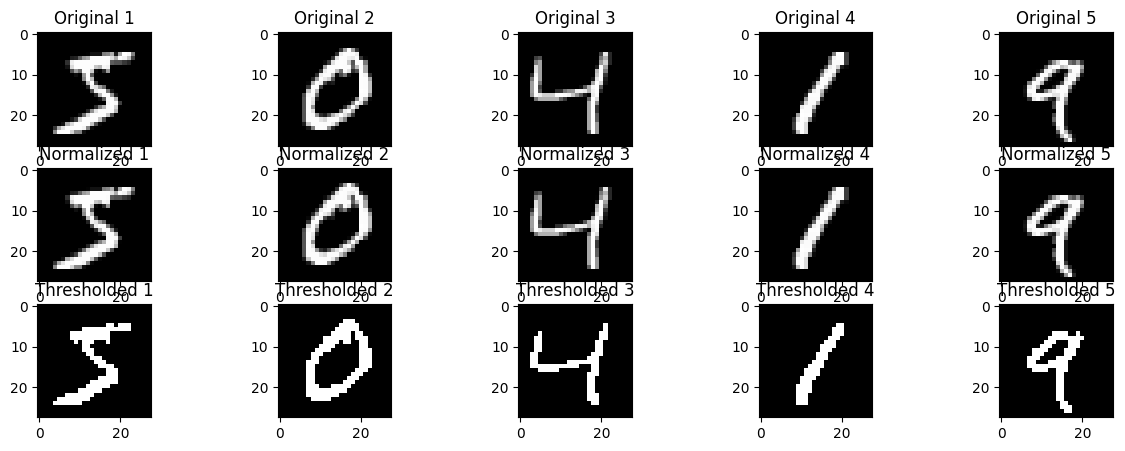

In [4]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values to the range [0, 1]
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0

#preprocessing to make data 1 and 0 to apply hamming network later

# Threshold the normalized values to 1 if >= 0.5
x_train_thresholded = np.round(np.where(x_train_normalized >= 0.5, 1.0, 0.0))
x_test_thresholded = np.round(np.where(x_test_normalized >= 0.5, 1.0, 0.0))

num_samples = 5

plt.figure(figsize=(15, 5))

for i in range(num_samples):
    # Original Image
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Original {i + 1}")

    # Normalized Image
    plt.subplot(3, num_samples, num_samples + i + 1)
    plt.imshow(x_train_normalized[i], cmap='gray')
    plt.title(f"Normalized {i + 1}")

    # Thresholded Image
    plt.subplot(3, num_samples, 2 * num_samples + i + 1)
    plt.imshow(x_train_thresholded[i], cmap='gray')
    plt.title(f"Thresholded {i + 1}")

plt.show()

In [5]:
print(x_train_thresholded[0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0

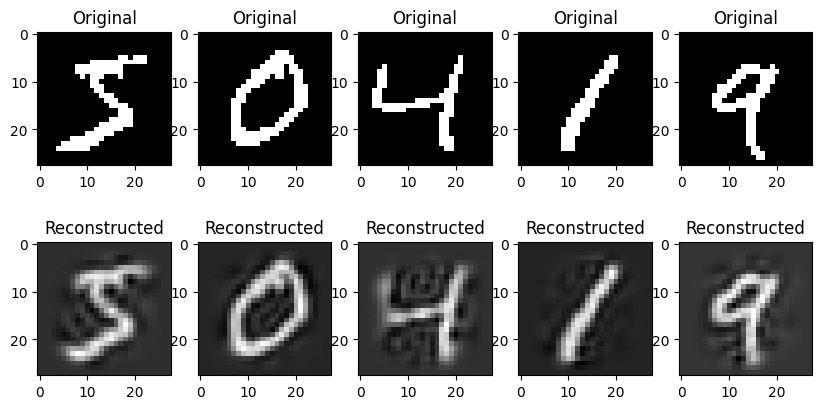

In [6]:
original_images = x_train_thresholded.reshape(len(x_train_thresholded), -1)

# Display some original samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_thresholded[i], cmap='gray')
    plt.title('Original')

# Apply PCA
n_components = 100
pca = PCA(n_components=n_components)
pca.fit(original_images)
pca_result = pca.transform(original_images)

# Reconstruct the images
reconstructed_images = pca.inverse_transform(pca_result)

# Reshape reconstructed images
reconstructed_images = reconstructed_images.reshape(len(x_train_thresholded), 28, 28)

# Display some reconstructed samples
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title('Reconstructed')

plt.show()


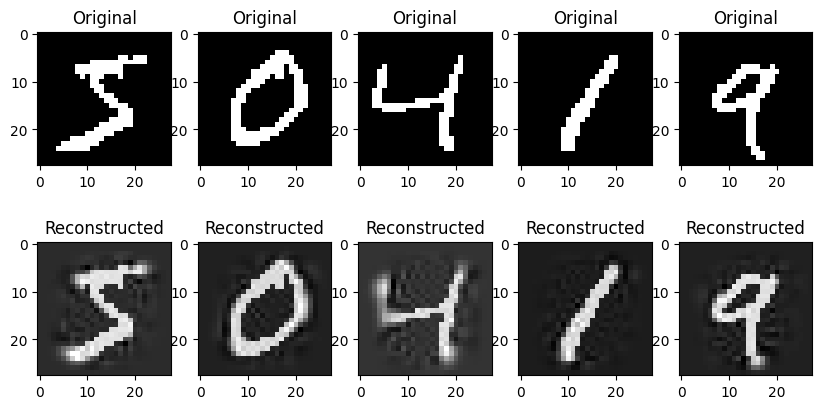

In [7]:
# Display some original samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_thresholded[i], cmap='gray')
    plt.title('Original')
# Apply PCA
n_components = 250
pca = PCA(n_components=n_components)
pca.fit(original_images)
pca_result = pca.transform(original_images)

# Reconstruct the images
reconstructed_images = pca.inverse_transform(pca_result)

# Reshape reconstructed images
reconstructed_images = reconstructed_images.reshape(len(x_train_thresholded), 28, 28)

# Display some reconstructed samples
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title('Reconstructed')

plt.show()

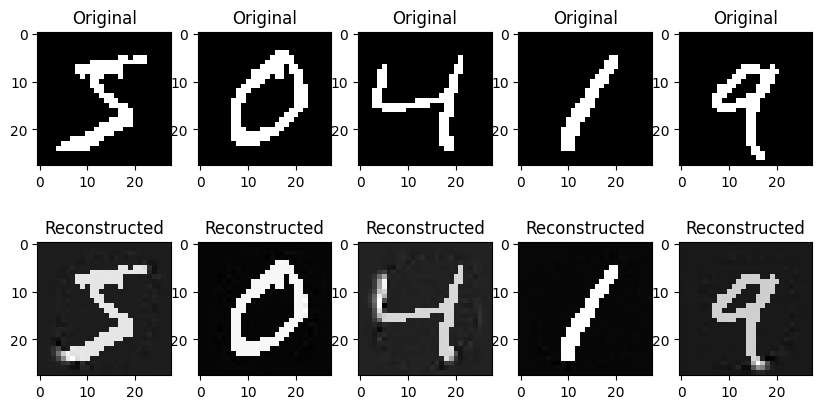

In [8]:
# Display some original samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_thresholded[i], cmap='gray')
    plt.title('Original')
# Apply PCA
n_components = 400
pca = PCA(n_components=n_components)
pca.fit(original_images)
pca_result = pca.transform(original_images)

# Reconstruct the images
reconstructed_images = pca.inverse_transform(pca_result)

# Reshape reconstructed images
reconstructed_images = reconstructed_images.reshape(len(x_train_thresholded), 28, 28)

# Display some reconstructed samples
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title('Reconstructed')

plt.show()

In [9]:
x = x_train_thresholded.reshape(len(x_train_thresholded), -1)
mean = np.mean(x, axis=0)
centered_data = x - mean
cov_matrix = np.cov(centered_data, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

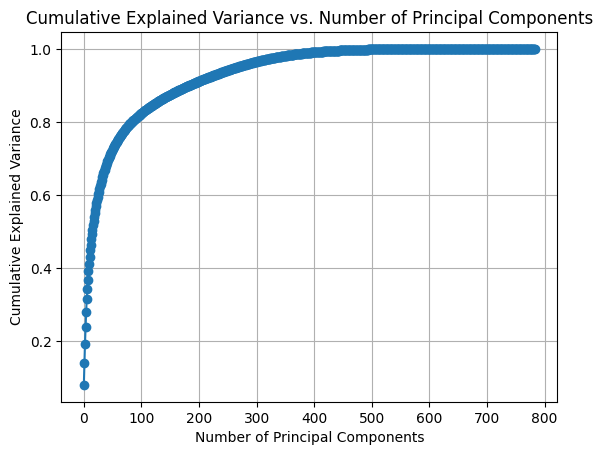

In [10]:
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()

#From the above plot and the trails of different Q-matrices the result is best at 400 component and doesnt chane alot with Q-matrix more than 400  #

#**After applying PCA and using the right Q-matrix the result looks like the orginal image with small differences so we reduced the data deminsions while saving all its important information"features" and with only 400 feature we represented our 784 feature**

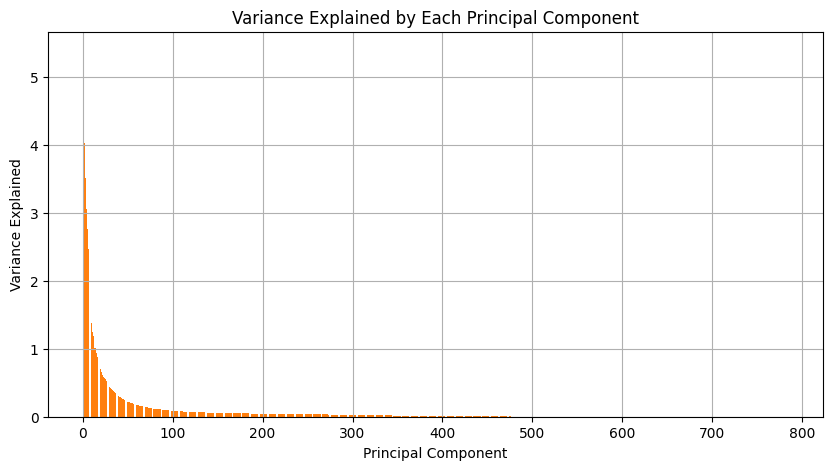

In [11]:
explained_variance = eigenvalues
plt.figure(figsize=(10, 5))
indices = np.arange(1, len(explained_variance) + 1)
plt.bar(indices, explained_variance[indices - 1])
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Principal Component')
plt.grid()
plt.show()

# Phase 2:

K-means Clustering Implementation

In [ ]:
'''
# k-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(x_train_thresholded)
centroids = kmeans.clustercenters
'''

'\n# k-means clustering \nfrom sklearn.cluster import KMeans\nkmeans = KMeans(n_clusters=10, random_state=42)\nkmeans_labels = kmeans.fit_predict(x_train_thresholded)\ncentroids = kmeans.clustercenters\n'

In [12]:
def k_means(X, k, iters=100):
    # Initialize centroids randomly
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]

    for _ in range(iters):
        # Assign each data point to the nearest centroid
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)

        # Update centroids based on the mean of assigned data points
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels

Hamming Network Implementation

In [13]:
def hamming_network_cluster(input_vector, centroids):
    # Calculate weights by dividing each feature in the cluster by 2
    weights_matrix = centroids / 2
    n=input_vector.shape[0]
    # Calculate (bias) theta by dividing the number of features by 2
    theta = np.ones(( weights_matrix.shape[0],1)) * (- n/2)
    input_vector= input_vector.reshape(1,input_vector.shape[0])

    net_input = np.dot(weights_matrix, input_vector.T) + theta

    # Take the absolute value of the vector
    net_input_abs = np.abs(net_input)

    # Choose the smallest value; it means the point vector belongs to this cluster and is the winner class
    winner_clusters = np.argmin(net_input_abs, axis=0)

    return winner_clusters

In [14]:
def evaluate_accuracy(predictions, targets):
    accuracy = np.mean(predictions == targets)
    return accuracy

In [15]:
# Getting the centroids for the PCA version of the data
centroids , labels = k_means(pca_result,k=10)

In [16]:
# Evaluating the model (PCA version)
winner_clusters = []
for i in range (pca_result.shape[0]):
  winner_cluster = hamming_network_cluster(pca_result[i],centroids)
  winner_clusters.append(winner_cluster[0])



accuracy_1 = evaluate_accuracy(winner_clusters , labels)
print(accuracy_1)

0.9020166666666667


In [20]:
# Getting the centroids for the original data
original_centroids , labels = k_means(original_images,k=10)

In [21]:
# Evaluating the model
winner_clusters = []
for i in range (pca_result.shape[0]):
  winner_cluster = hamming_network_cluster(original_images[i],original_centroids)
  winner_clusters.append(winner_cluster[0])



accuracy_2 = evaluate_accuracy(winner_clusters , labels)
print(accuracy_2)

0.7119166666666666
